2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
LSTM MAE: 0.635, RMSE: 0.915, R²: 0.964


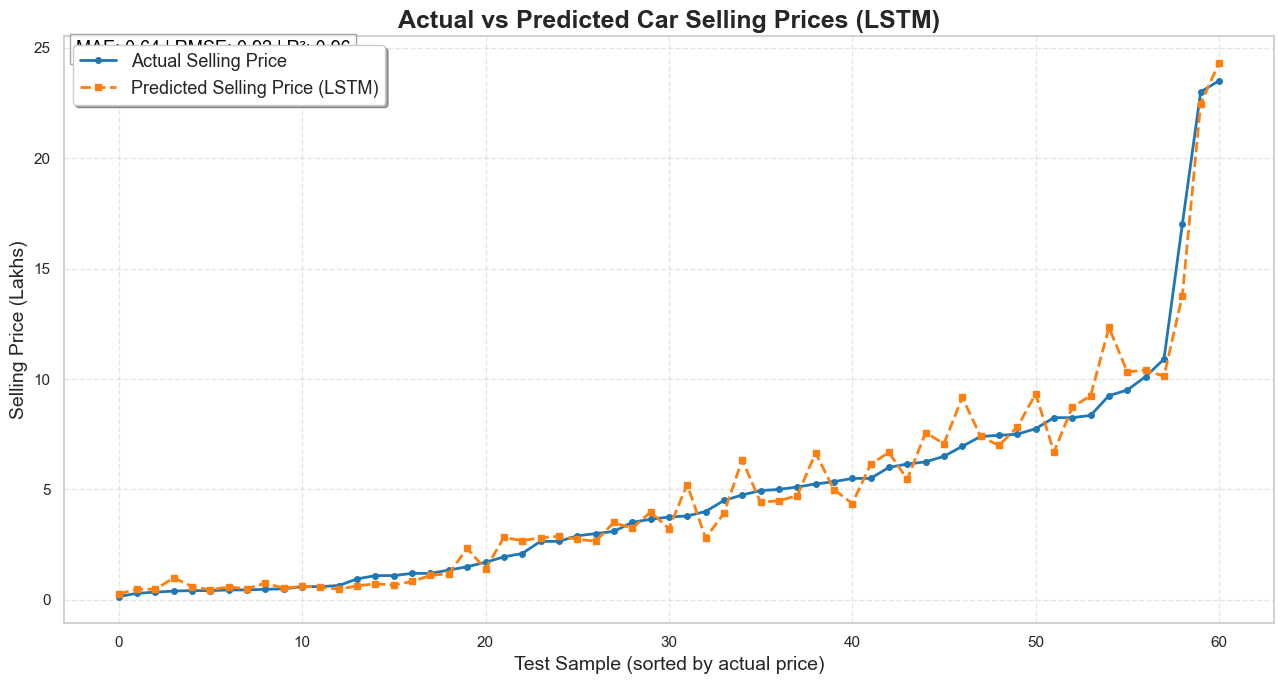

In [1]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
import seaborn as sns

# 2. Load Data
df = pd.read_csv(r"C:\Users\bhavya gupta\Downloads\archive (1)\car data.csv")

# 3. Data Preprocessing
df['Car_Age'] = 2024 - df['Year']
df = df.drop(['Car_Name', 'Year'], axis=1)

categorical = ['Fuel_Type', 'Selling_type', 'Transmission']
numerical = ['Present_Price', 'Driven_kms', 'Owner', 'Car_Age']
target = 'Selling_Price'

# ColumnTransformer for encoding
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical)
], remainder='passthrough')

X = df.drop(target, axis=1)
y = df[target].values

# Fit and transform features
X_processed = preprocessor.fit_transform(X)

# Feature scaling
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_processed)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1,1)).flatten()

# 4. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# 5. LSTM Model
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

model = Sequential([
    Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_lstm, y_train, epochs=40, batch_size=32, verbose=0)

# 6. Predictions
y_pred_lstm = model.predict(X_test_lstm).flatten()
y_pred_lstm_inv = scaler_y.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten()
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 7. Evaluation
mae = mean_absolute_error(y_test_inv, y_pred_lstm_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_lstm_inv))
r2 = r2_score(y_test_inv, y_pred_lstm_inv)
print(f"LSTM MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")

# 8. Plot
plt.figure(figsize=(13,7))
sns.set(style="whitegrid")
sorted_idx = np.argsort(y_test_inv)
plt.plot(y_test_inv[sorted_idx], label='Actual Selling Price', color='#1f77b4', linewidth=2, marker='o', markersize=4)
plt.plot(y_pred_lstm_inv[sorted_idx], label='Predicted Selling Price (LSTM)', color='#ff7f0e', linewidth=2, marker='s', markersize=4, linestyle='--')
plt.title('Actual vs Predicted Car Selling Prices (LSTM)', fontsize=18, fontweight='bold')
plt.xlabel('Test Sample (sorted by actual price)', fontsize=14)
plt.ylabel('Selling Price (Lakhs)', fontsize=14)
plt.legend(fontsize=13, loc='upper left', frameon=True, shadow=True)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.text(0.01, 0.97, f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.2f}",
         transform=plt.gca().transAxes, fontsize=13, color='black', 
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
plt.show()
